# calculates the seasonal anomalies and the seasonal tercile categories from the gridded VCSN monthly files, using the NZ 6 regions shapefiles, and using the 'CLIOPS' methodology 

In [1]:
# Paramaters 

# var_name = 'Rain_bc'
# var_name = 'Tmin_N'
# var_name = 'Tmax_N'
var_name = 'Tmean'
# var_name = 'SoilM'
# var_name = 'Wind'
# var_name = 'Rad'

in ['Agent', 'Lat', 'Longt', 'Date', 'MSLP', 'PET', 'Rain', 'RH', 'SoilM',
       'ETmp', 'Rad', 'TMax', 'Tmin', 'VP', 'Wind', 'Rain_bc', 'Tmax_N',
       'Tmin_N']

In [2]:
import os
import sys
import pathlib

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from itertools import product

In [4]:
import salem
import geopandas as gpd

In [5]:
import xarray as xr

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [6]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

In [7]:
var_name

'Tmean'

### big_var is the simplified version of the variable, so Rain_bc --> RAIN

In [8]:
big_var = var_name.split('_')[0].upper()

In [9]:
HOME = pathlib.Path.home()

In [10]:
dpath = HOME / 'operational/VCSN/data/NC/MONTHLY/' / var_name.upper()

In [11]:
var_name.upper()

'TMEAN'

In [12]:
dpath

PosixPath('/home/nicolasf/operational/VCSN/data/NC/MONTHLY/TMEAN')

In [13]:
dset = salem.open_xr_dataset(dpath / f'VCSN_gridded_{var_name}_1979-01_2019-12.nc') 

In [14]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-12-31
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
Data variables:
    agent    (lat, lon) float32 ...
    Tmean    (time, lat, lon) float64 ...
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

### calculates the seasonal average (or sum if Rain_bc is the variable )

In [15]:
if var_name == 'Rain_bc': 
    dset = dset.rolling(time=3, min_periods=3).sum()
else: 
    dset = dset.rolling(time=3, min_periods=3).mean()

In [16]:
dset = dset.isel(time=slice(2,None))

In [17]:
nz_regions = gpd.read_file(HOME / 'research' / 'Smart_Ideas' / 'data' / 'shapefiles' / 'NZ_regions' / 'NZ_6_regions' / 'NZ_regions_corrected.shp') 

In [18]:
nz_regions

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,Location,geometry
0,1,1,1,85.215338,5.032753,NNI,"MULTIPOLYGON (((174.70530 -38.17377, 174.70545..."
1,2,2,2,12.336015,2.994028,WNI,"MULTIPOLYGON (((175.13516 -41.37745, 175.13507..."
2,3,3,3,14.235493,3.775388,ENI,"MULTIPOLYGON (((175.85595 -41.35970, 175.85595..."
3,4,4,4,34.656463,3.066280,NSI,"MULTIPOLYGON (((171.32620 -42.12355, 171.32602..."
4,5,5,6,20.191504,4.827228,ESI,"MULTIPOLYGON (((170.21675 -46.05955, 170.21609..."
5,6,6,5,42.941379,9.057410,WSI,"MULTIPOLYGON (((169.20749 -46.66371, 169.20742..."


#### checks that the crs is correct: should be epsg 4272 

In [19]:
nz_regions.crs

<Geographic 2D CRS: EPSG:4272>
Name: NZGD49
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: New Zealand - onshore and nearshore
- bounds: (165.87, -47.65, 179.27, -33.89)
Datum: New Zealand Geodetic Datum 1949
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [20]:
opath_root = HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'targets' / 'NZ_regions' / 'NZ_6_regions' / 'CLIOPS'

In [21]:
if not opath_root.exists(): 
    opath_root.mkdir(parents=True)

### defines the number of quantiles we want 

In [22]:
num_quantiles = 3

In [23]:
quant_values = np.linspace(0, 1, num_quantiles + 1, endpoint=True)

In [24]:
quant_values = quant_values[1:-1]

In [25]:
quant_values

array([0.33333333, 0.66666667])

In [26]:
col_labs = [f"Q{int(x)}" for x in (quant_values*100)]

In [27]:
col_labs

['Q33', 'Q66']

In [38]:
%%writefile /home/nicolasf/research/Smart_Ideas/code/ml4seas/utils/calculate_quantile.py 
def calculate_quantile(ts_series, quant_values): 
    
    """
    given one Pandas Series containing seasonally aggregated values (Note: NOT a dataframe) 
    and a list of quantiles, calculates the quantile category for each season 
    
    climatology by default is 1981 - 2010
    
    Parameters
    ----------
    
    - ts_series : a Pandas Series, with datetime index 
    - quant_values : a list of quantiles (e.g. [0.3333, 0.66666] for terciles)
    
    Return
    ------
    
    - ts_series_cat : a Pandas Series with the corresponding category 
    
    """
    
    ts_series_cat = []
    
    quantiles_list = []

    for month in range(1, 13):

        ts_series_m = ts_series[ts_series.index.month == month]

        clim = ts_series_m.loc['1981':'2010']

        quantiles = [clim.quantile(q=q) for q in quant_values.tolist()]

        quantiles_list.append(quantiles.copy())

        quantiles.insert(0, -np.inf)

        quantiles.append(np.inf)

        ts_series_m_cats = pd.cut(ts_series_m, quantiles, labels=list(range(1, num_quantiles + 1)))

        ts_series_cat.append(ts_series_m_cats)

        del(quantiles) 
        
    ts_series_cat = pd.concat(ts_series_cat)
    
    ts_series_cat = ts_series_cat.sort_index()
    
    return ts_series_cat 

Writing /home/nicolasf/research/Smart_Ideas/code/ml4seas/utils/calculate_quantile.py


In [39]:
%%writefile /home/nicolasf/research/Smart_Ideas/code/ml4seas/utils/calculate_anomalies.py 
def calculate_anomalies(ts_series): 
    
    """
    given one Pandas Series containing seasonally aggregated values (Note: NOT a dataframe) 
    calculates the anomaly for each season 
    
    climatology by default is 1981 - 2010
    
    Parameters
    ----------
    
    - ts_series : a Pandas Series, with datetime index 
    
    Return
    ------
    
    - ts_series_anoms : Pandas Series with the corresponding anomalies 
    
    """
    
    def demean(x): 
        return x - x.loc['1981':'2010',].mean()
    
    ts_series_anoms = ts_series.groupby(ts_series.index.month).apply(demean) 
    
    ts_series_anoms = ts_series_anoms.sort_index()
    
    return ts_series_anoms


Writing /home/nicolasf/research/Smart_Ideas/code/ml4seas/utils/calculate_anomalies.py


### loop over the regions 

In [30]:
for region_name in ['NNI','ENI','WNI','NSI','WSI','ESI']: 
    
    print(f"processing {region_name}")
    
    shape = nz_regions.query(f"Location == '{region_name}'")
    
    region = dset.salem.subset(shape=shape)
    
    region = region.salem.roi(shape=shape, all_touched=True)
    
    region_stacked = region.stack(z=('lat','lon'))
    
    region_stacked = region_stacked.dropna(dim='z')
    
    n_points = len(region_stacked.z) 
    
    df_cat = []
    df_anoms = []
    
    for z in region_stacked.z.data: 
    
        ts_series = region_stacked.sel(z=z).to_dataframe()[var_name]
    
        df_cat.append(calculate_quantile(ts_series, quant_values))
    
        df_anoms.append(calculate_anomalies(ts_series)) 
        
    df_cat = pd.concat(df_cat, axis=1)
        
    df_anoms = pd.concat(df_anoms, axis=1) 
    
    df_cat = df_cat.sort_index() 
    
    df_anoms = df_anoms.sort_index() 
    
    df_anoms = df_anoms.mean(axis=1)
    
    df_anoms = df_anoms.to_frame(name='anoms')
        
    df_cat_freq = df_cat.apply(pd.value_counts, axis=1) / n_points
    
    df_cat_freq = df_cat_freq.fillna(value=0)
    
    df_cat_freq.loc[:,'cat_3'] = df_cat_freq.idxmax(axis=1)
    
    df_cat_freq.loc[:,'n_points'] = n_points
    
    df = pd.concat([df_cat_freq, df_anoms], axis=1)
    
    opath = opath_root / big_var / region_name 
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
        
    fout = opath / f'TS_NZ_region_{region_name}_{big_var}_{num_quantiles}_quantiles_anoms_cliops.csv' 
    
    df.to_csv(fout)
    
    if fout.exists(): 
        print(f"successfully created {str(fout)}")

    else: 
        print(f"something went wrong trying to save {str(fout)}")

processing NNI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS/TMEAN/NNI/TS_NZ_region_NNI_TMEAN_3_quantiles_anoms_cliops.csv
processing ENI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS/TMEAN/ENI/TS_NZ_region_ENI_TMEAN_3_quantiles_anoms_cliops.csv
processing WNI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS/TMEAN/WNI/TS_NZ_region_WNI_TMEAN_3_quantiles_anoms_cliops.csv
processing NSI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS/TMEAN/NSI/TS_NZ_region_NSI_TMEAN_3_quantiles_anoms_cliops.csv
processing WSI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS/TMEAN/WSI/TS_NZ_region_WSI_TMEAN_3_quantiles_anoms_cliops.csv
processing ESI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regi

### EOF 

### comparison with other definition 

In [31]:
var_name

'Tmean'

In [32]:
if var_name == 'Rain_bc': 
    var_name = var_name.split('_')[0]

In [33]:
opath_root

PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS')

In [34]:
reg_match = {}

for region_name in ['NNI','ENI','WNI','NSI','WSI','ESI']: 
    
    df_cliops = pd.read_csv(opath_root / var_name.upper() / region_name / f"TS_NZ_region_{region_name}_{var_name.upper()}_3_quantiles_anoms_cliops.csv", index_col=0, parse_dates=True)
    
    df_orig = pd.read_csv(opath_root.parent / var_name.upper() / region_name / f"TS_NZ_region_{region_name}_{var_name.upper()}_3_quantiles_anoms.csv", index_col=0, parse_dates=True)
    
    reg_match[region_name] = (df_orig.cat_3 == df.cat_3).sum() / len(df)
    

In [35]:
pd.Series(reg_match)

NNI    0.677551
ENI    0.693878
WNI    0.702041
NSI    0.736735
WSI    0.775510
ESI    0.963265
dtype: float64

In [36]:
df_cliops

,1,2,3,cat_3,n_points,anoms
time,,,,,,
1979-03-31,0.4405,0.5175,0.0420,2,2000,-0.283684
1979-04-30,0.4115,0.5845,0.0040,2,2000,-0.320514
1979-05-31,0.9410,0.0590,0.0000,1,2000,-0.602066
1979-06-30,0.6845,0.3155,0.0000,1,2000,-0.318733
1979-07-31,0.0105,0.6995,0.2900,2,2000,0.091800
...,...,...,...,...,...,...
2019-08-31,0.0000,0.0175,0.9825,3,2000,0.707081
2019-09-30,0.0040,0.1685,0.8275,3,2000,0.524083
2019-10-31,0.8935,0.1065,0.0000,1,2000,-0.427972


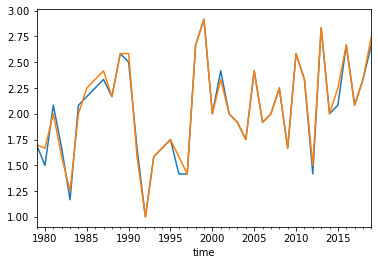

In [37]:
f, ax = plt.subplots()
df_orig.cat_3.resample('A').mean().plot(ax=ax)
df_cliops.cat_3.resample('A').mean().plot(ax=ax)